# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [1]:
%run "../config/notebook_settings.py"

from helpers.utilities import Timer, get_logger
from helpers.text_processing import count_tokens, tf_idf, get_context_from_keyword

def get_project_directory():
    return os.getcwd().replace('/source/executables', '')

print(get_project_directory())

/Users/shanekercheval/repos/nlp-template


In [2]:
with Timer("Loading Data"):
    path = os.path.join(get_project_directory(), 'artifacts/data/processed/un-general-debates-blueprint.pkl')
    df = pd.read_pickle(path)

Started: Loading Data
Finished (1.36 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [3]:
hlp.pandas.numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
session,"7,507",0,0.0%,0,0.0%,49.6,12.9,0.3,-0.2,-1.1,25,31.0,39.0,51.0,61.0,67.0,70
year,"7,507",0,0.0%,0,0.0%,"1,994.6",12.9,0.0,-0.2,-1.1,"1,970","1,976.0","1,984.0","1,996.0","2,006.0","2,012.0","2,015"
text_length,"7,507",0,0.0%,0,0.0%,"17,967.3","7,860.0",0.4,1.1,1.8,"2,362","9,553.8","12,077.0","16,424.0","22,479.5","28,658.2","72,041"
num_tokens,"7,507",0,0.0%,0,0.0%,"1,480.3",635.2,0.4,1.1,1.7,187,793.6,"1,005.5","1,358.0","1,848.0","2,336.4","5,688"
num_bi_grams,"7,507",0,0.0%,0,0.0%,588.5,243.6,0.4,1.0,1.6,58,321.0,408.0,544.0,726.0,912.0,"2,185"


In [4]:
hlp.pandas.non_numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"7,507",0,0.0%,ALB,199,2.7%
country_name,"7,507",0,0.0%,Albania,199,2.7%
speaker,"7,507",0,0.0%,<unknown>,"5,429",72.3%
position,"7,507",0,0.0%,<unknown>,114,1.5%
text,"7,507",0,0.0%,33: May I first convey to our [...],"7,507",100.0%
tokens,"7,507",0,0.0%,"['may', 'first', 'convey', 'pr[...]","7,507",100.0%
bi_grams,"7,507",0,0.0%,"['first convey', 'albanian del[...]","7,507",100.0%


---

In [5]:
df['text'].iloc[0][0:1000]

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles wh

In [6]:
'|'.join(df['tokens'].iloc[0])[0:1000]

'may|first|convey|president|congratulations|albanian|delegation|election|presidency|twenty-fifth|session|general|assembly|taking|work|agenda|twenty-|fifth|session|general|assembly|held|eve|twenty-fifth|anniversary|coming|force|charter|united|nations|peace-loving|member|states|would|wished|position|present|occasion|picture|positive|satisfactory|activity|part|united|nations|albanian|delegation|part|would|taken|great|pleasure|drawing|balance|sheet|activities|covering|quarter|century|certainly|short|period|life|international|organization|unfortunately|situation|created|day|victory|achieved|powers|rome|berlintokyo|axis|conceived|spirit|principles|predominated|war|antifascist|coalition|organization|awakened|whole|progressive|humanity|hope|would|serve|important|factor|creating|better|international|conditions|order|favor|cause|freedom|peace|world|security|activities|number|events|occurred|world|arena|period|disappointed|hopes|peoples|united|nations|far|contributed|required|fundamental|provisio

In [7]:
'|'.join(df['bi_grams'].iloc[0])[0:1000]

'first convey|albanian delegation|twenty-fifth session|general assembly|twenty- fifth|fifth session|general assembly|twenty-fifth anniversary|united nations|peace-loving member|member states|states would|satisfactory activity|united nations|albanian delegation|part would|taken great|great pleasure|balance sheet|activities covering|short period|international organization|organization unfortunately|situation created|rome berlintokyo|berlintokyo axis|antifascist coalition|organization awakened|progressive humanity|would serve|important factor|creating better|better international|international conditions|freedom peace|world security|world arena|period disappointed|united nations|nations far|fundamental provisions|international peace|liberation struggle|imperialist powers|united states|america foremost|foremost among|path diametrically|diametrically opposed|instrument favoring|pillage oppression|peace-loving peoples|united nations|committing aggression|many parts|frequently helped|direction

## Explore Non-Text Columns

Explore idiosyncrasies of various columns, e.g. same speaker represented multiple ways.

In [8]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

---

## Explore Text Column|

### Top Words Used

In [9]:
count_tokens(df['tokens']).head(20)

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


---

### Distribution of Text Length

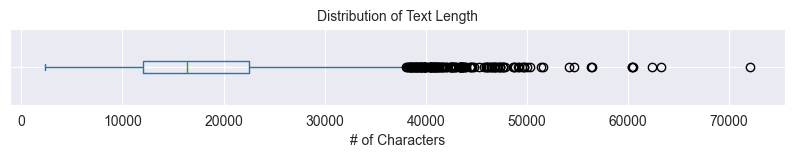

In [10]:
ax = df['text_length'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Text Length")
ax.set_xlabel("# of Characters")
ax.set_yticklabels([])
ax;

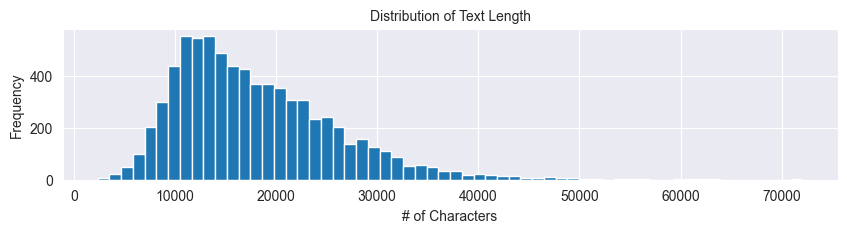

In [11]:
ax = df['text_length'].plot(kind='hist', bins=60, figsize=(10, 2));
ax.set_title("Distribution of Text Length")
ax.set_xlabel("# of Characters")
ax;

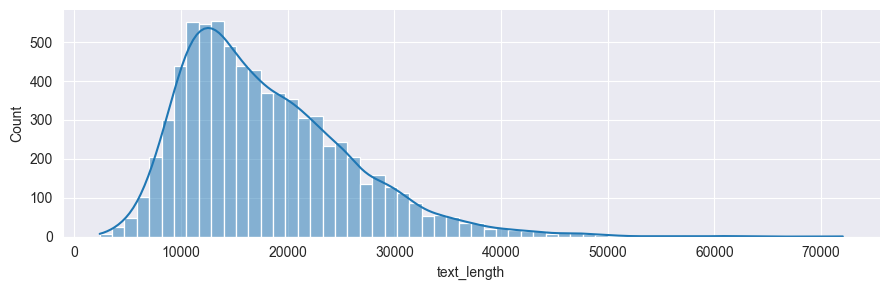

In [12]:
import seaborn as sns
sns.displot(df['text_length'], bins=60, kde=True, height=3, aspect=3);

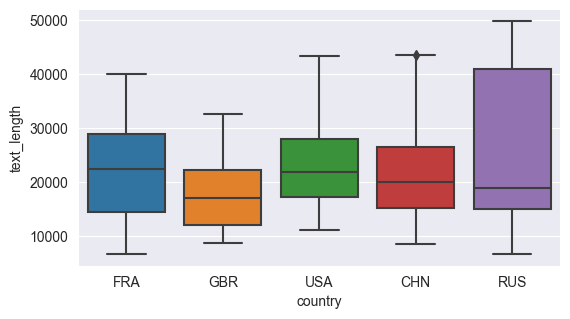

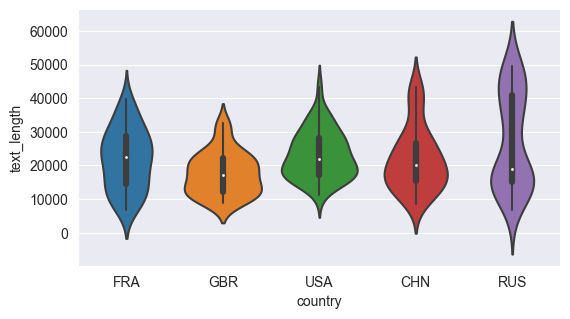

In [13]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="text_length", kind='box')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="country", y="text_length", kind='violin')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)

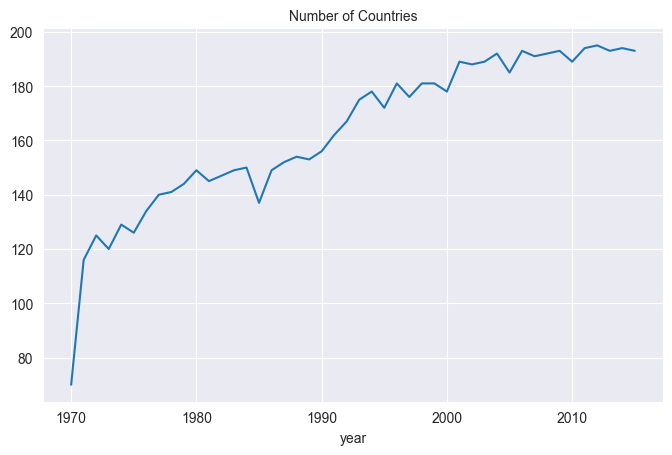

In [14]:
assert not df[['year', 'country']].duplicated().any()
df.groupby('year').size().plot(title="Number of Countries");

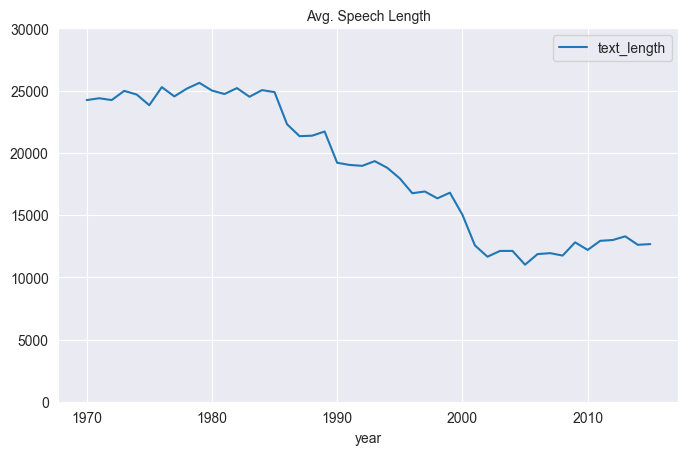

In [15]:
df.groupby('year').agg({'text_length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000));

### Word Frequency

In [16]:
counts_df = count_tokens(df['tokens'])

In [17]:
counts_df.head()

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [18]:
def plot_wordcloud(frequency_dict):
    wc = wordcloud.WordCloud(background_color='white',
        #colormap='RdYlGn',
        colormap='tab20b',
        width=round(hlp.plot.STANDARD_WIDTH*100),
        height=round(hlp.plot.STANDARD_HEIGHT*100),
        max_words = 200, max_font_size=150,
        random_state=42
    )
    wc.generate_from_frequencies(frequency_dict)

    fig, ax = plt.subplots(figsize=(hlp.plot.STANDARD_WIDTH, hlp.plot.STANDARD_HEIGHT))
    ax.imshow(wc, interpolation='bilinear')
    #plt.title("XXX")
    plt.axis('off')

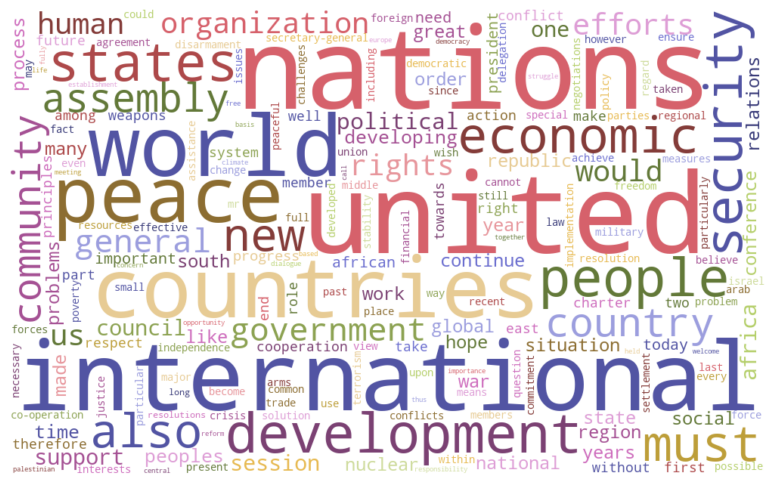

In [19]:
plot_wordcloud(counts_df.to_dict()['frequency']);

### TF-IDF

In [20]:
tf_idf_df = tf_idf(
    df=df,
    tokens_column='tokens',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
)

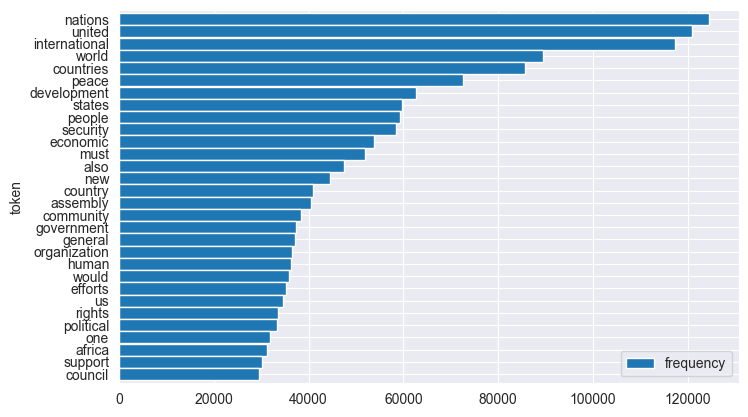

In [37]:
ax = tf_idf_df.sort_values(by='frequency', ascending=False).head(30)[['frequency']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

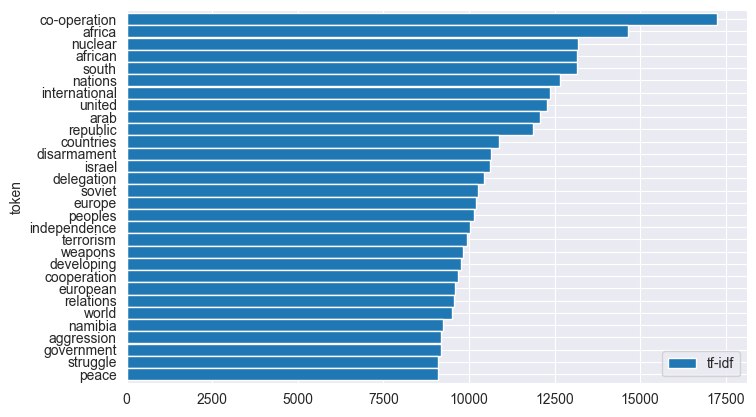

In [21]:
ax = tf_idf_df.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

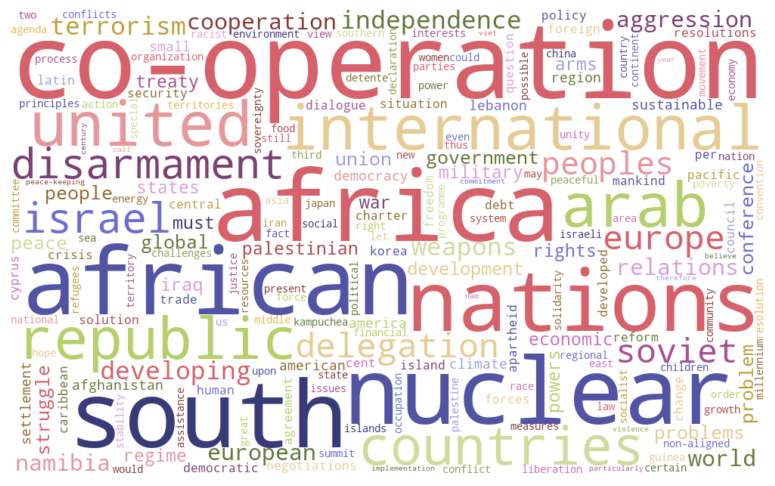

In [22]:
plot_wordcloud(tf_idf_df.to_dict()['tf-idf']);

#### Per Year - 1970

In [23]:
tf_idf_per_year = tf_idf(
    df=df,
    tokens_column='tokens',
    segment_columns = 'year',
    min_frequency_corpus=10,
    min_frequency_document=10,
)

In [24]:
stop_words = ['twenty-fifth', 'twenty-five', 'twenty', 'fifth']
tokens_to_show = tf_idf_per_year.query('year == 1970').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]

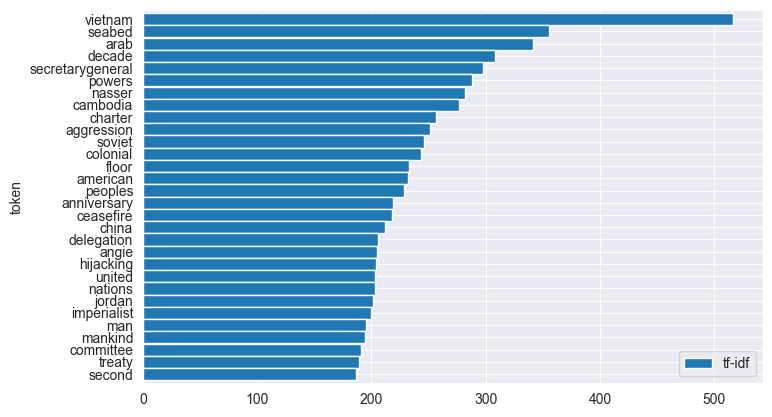

In [25]:
ax = tokens_to_show.head(30).set_index('token')[['tf-idf']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

In [26]:
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']

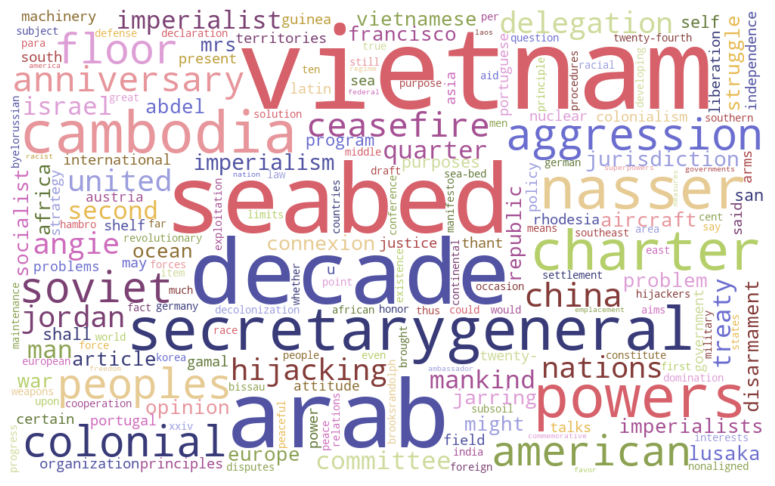

In [27]:
plot_wordcloud(tokens_to_show);

#### Per Year - 2015

In [28]:
stop_words = ['seventieth']
tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]

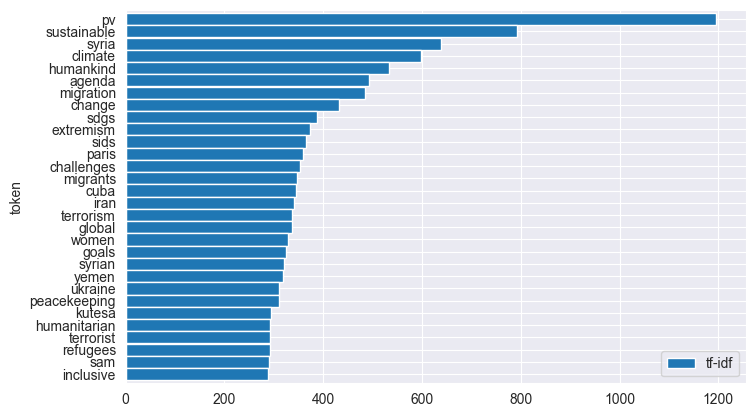

In [29]:
ax = tokens_to_show.head(30).set_index('token')[['tf-idf']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

In [30]:
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']

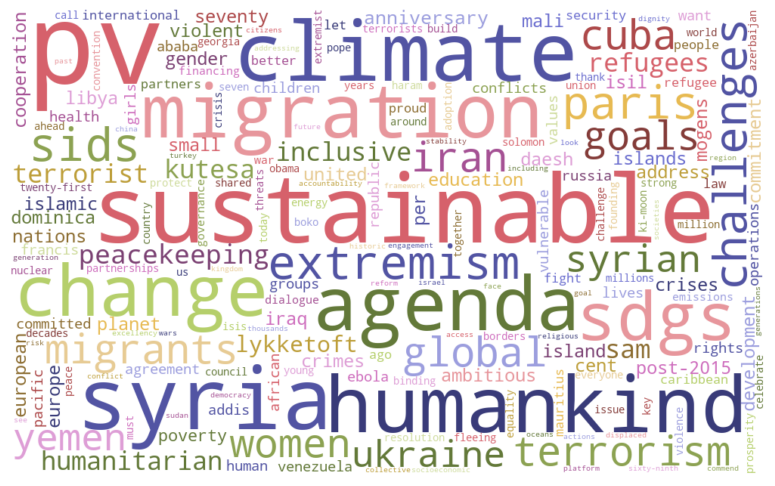

In [31]:
plot_wordcloud(tokens_to_show);

### Keywords in Context

In [32]:
contexts = get_context_from_keyword(
    documents=df[df['year'] == 2015]['text'],
    window_width=50,
    keyword='sdgs', random_seed=42
)
for x in contexts:
    print(x)

-29946  03/10/2015 A/70/PV.28 Development Goals ( |SDGs| ). Beyond the immediate present, the Commonwealth 
nd collectively, to ensure the realization of the  |SDGs| . The Commonwealth of Dominica is therefore encour
that and other initiatives aimed at achieving the  |SDGs| . SIDS are equally concerned about sustainably uti
n of the post-2015 Sustainable Development Goals ( |SDGs| ). I should like to take this opportunity to conve
nian State. We must ensure the realization of the  |SDGs|  in a timely manner. We hope that the upcoming cli
s to translate the Sustainable Development Goals ( |SDGs| ) 15-29664 21/25  A/70/PV.23 01/10/2015 of the ne
w Agenda into action. That can happen only if the  |SDGs|  are matched with the necessary resources, in acco
, smart and innovatively to achieve the 17 global  |SDGs|  and the 169 targets. It has to be driven by a new
t for our rural population in accordance with the  |SDGs| . The leaders of the Pacific small island developi
of the gender-relat

In [33]:
contexts = get_context_from_keyword(
    documents=df[df['year'] == 2015]['text'],
    window_width=50,
    keyword='sids', random_seed=42
)
for x in contexts:
    print(x)

ntry, our region, small island developing States ( |SIDS| ) and our planet. We decided then, as we have done
 to our planet, with a disproportionate impact on  |SIDS| . Our concerns have been magnified since 27 August
 of climate change has wreaked havoc on Caribbean  |SIDS| . In 2004, Hurricane Ivan, a category 3 system, wi
mpact of climate change and provide resources for  |SIDS|  to respond to those challenges. The recently conc
ean energy. Just a few days ago, on 27 September,  |SIDS|  demonstrated their leadership, by creating the fi
the first-ever intergovernmental organization for  |SIDS| , the Small Island Developing States Sustainable E
 Developing States Sustainable Energy Initiative ( |SIDS|  DOCK). The statute came into force with a members
inable energy and climate-resilient organization.  |SIDS|  DOCK is intended to provided a collective voice, 
this first-ever intergovernmental organization of  |SIDS| . 15-29946 11/33  A/70/PV.28 03/10/2015 On behalf
.28 03/10/2015 On b

In [34]:
contexts = get_context_from_keyword(
    documents=df[df['year'] == 2015]['text'],
    window_width=50,
    keyword='pv', random_seed=42
)
for x in contexts:
    print(x)

reed Sustainable 10/33 15-29946  03/10/2015 A/70/ |PV| .28 Development Goals (SDGs). Beyond the immediate
ental organization of SIDS. 15-29946 11/33  A/70/ |PV| .28 03/10/2015 On behalf of the States members of 
lic of China has 12/33 15-29946  03/10/2015 A/70/ |PV| .28 brought about major improvements in our countr
g and United Nations reform. 15-29822 5/29  A/70/ |PV| .26 02/10/2015 Two years ago in this very forum (s
0/2015 Two years ago in this very forum (see A/68/ |PV| .22), the Philippines outlined the five pillars th
ly engaged in the 6/29 15-29822  02/10/2015 A/70/ |PV| .26 United Nations system. Indeed, the partnership
ersations on the much-needed 15-29822 7/29  A/70/ |PV| .26 02/10/2015 and long-overdue reforms to make th
iation to the United Nations 15-29822 3/29  A/70/ |PV| .26 02/10/2015 Secretary-General for his leadershi
onal institutions 4/29 15-29822  02/10/2015 A/70/ |PV| .26 such as ASEAN should be be further strengthene
ne refugee issue 26/54 15-29562  30/

---

## Bi-Grams

In [38]:
tf_idf_df = tf_idf(
    df=df,
    tokens_column='bi_grams',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
)

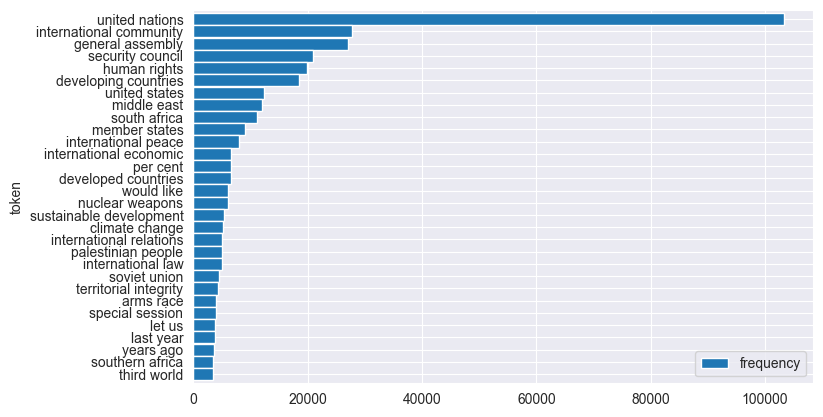

In [39]:
ax = tf_idf_df.sort_values(by='frequency', ascending=False).head(30)[['frequency']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

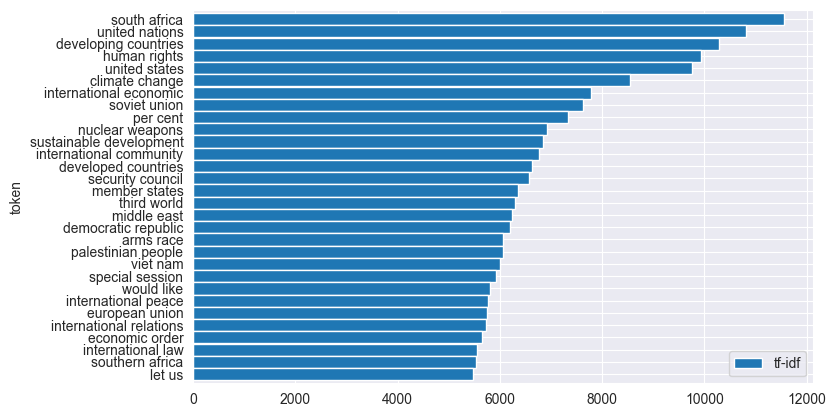

In [40]:
ax = tf_idf_df.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

#### By Year

In [59]:
tf_idf_per_year = tf_idf(
    df=df,
    tokens_column='bi_grams',
    segment_columns = 'year',
    min_frequency_corpus=3,
    min_frequency_document=3,
)

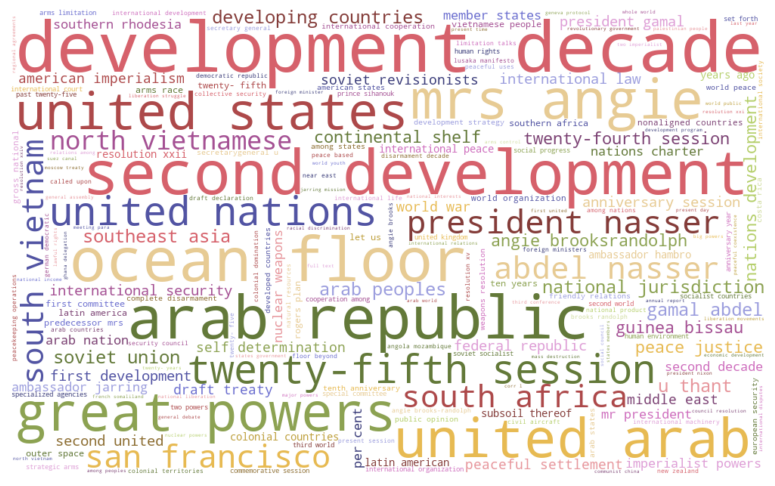

In [60]:
stop_words = ['twenty-fifth anniversary', 'twenty-five years', 'twenty years', 'twenty fifth']
tokens_to_show = tf_idf_per_year.query('year == 1970').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

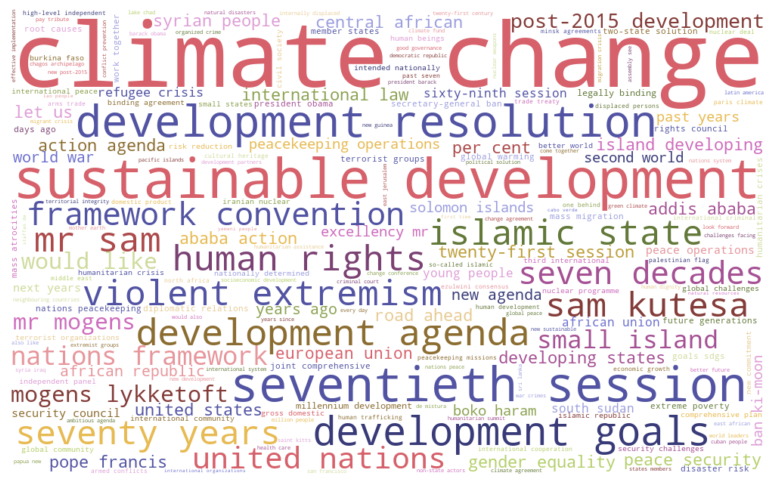

In [61]:
stop_words = ['seventieth anniversary']
tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);

In [63]:
stop_words = ['seventieth anniversary']
#tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tf_idf_per_year.reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]

# filter for "climate"
tokens_to_show = tokens_to_show[tokens_to_show['token'].str.contains('climate')]
tokens_to_show

,year,token,frequency,tf-idf
1286,1970,political climate,5,16.98
4895,1971,political climate,5,16.98
6127,1971,international climate,3,9.91
6579,1972,political climate,15,50.94
7822,1972,international climate,7,23.12
...,...,...,...,...
207523,2015,climate finance,3,20.16
207525,2015,fight climate,3,20.16
207821,2015,climate system,3,18.57
209036,2015,new climate,3,13.05


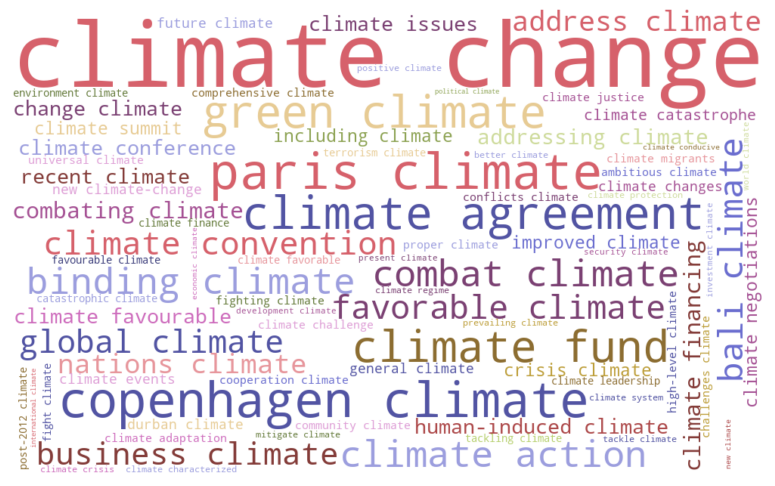

In [64]:
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']
plot_wordcloud(tokens_to_show);